# American and Bermudan Option pricer

In [1]:
# Packages used
import numpy as np
import matplotlib.pyplot as plt
from scipy import odr
from helper import GBM_Euler, value_option_schwarz, value_option_schwarz_test, value_option_bermudan
import keras
from scipy.stats import norm

## Simulations Run with Data from paper

American option should be priced at .1144

In [2]:
# Parameters
K=1.1; M=4; r=.06; realizations=8

# Matrix
path_matrix = np.array([
[1.00, 1.09, 1.08, 1.34],
[1.00, 1.16, 1.26, 1.54],
[1.00, 1.22, 1.07, 1.03],
[1.00, 0.93, 0.97, 0.92],
[1.00, 1.11, 1.56, 1.52],
[1.00, .76, 0.77, 0.90],
[1.00, 0.92, 0.84, 1.01],
[1.00, 0.88, 1.22, 1.34]])

In [294]:
# Generate cash flows under Longstaff-Schwarz
cash_flows = value_option_schwarz(M,K,path_matrix, r, realizations, option="put")

# Discount cash flows
for time in range(cash_flows.shape[1]):
    cash_flows[:,time]*=np.exp(-r*time)
print(f'Price of American Option is: {np.sum(cash_flows[0:])/realizations}')

Price of American Option is: 0.11443433004505696


In [295]:
cash_flows_test = value_option_schwarz_test(M,K,path_matrix, r, realizations, option="put")

# Discount cash flows
for time in range(cash_flows.shape[1]):
    cash_flows_test[:,time]*=np.exp(-r*time)
print(f'Price of American Option is: {np.sum(cash_flows_test[0:])/realizations}')    

Price of American Option is: 0.11443433004505696


In [296]:
# Unit test Bermudian pricer by giving it same amount of exericse options as American
exercise_dates = [1,2,3,4]
cash_flow_bermudan = value_option_bermudan(M, K, path_matrix, r, realizations, exercise_dates, option="put")

for time in range(cash_flow_bermudan.shape[1]):
    cash_flow_bermudan[:,time] *= np.exp(-r*time)
print(f'Price of Bermudan Option is: {np.sum(cash_flow_bermudan[0:])/realizations}')    

Price of Bermudan Option is: 0.11561153571203728


In [131]:
# Fewer exercise points should lead to lower option price
exercise_dates = [2,3,4]
cash_flow_bermudan = value_option_bermudan(M, K, path_matrix, r, realizations, exercise_dates, option="put")

for time in range(cash_flow_bermudan.shape[1]):
    cash_flow_bermudan[:,time] *= np.exp(-r*time)
print(f'Price of Bermudan Option is: {np.sum(cash_flow_bermudan[0:])/realizations}')    

Price of Bermudan Option is: 0.056380739270260896


In [132]:
# Unit test Bermudian pricer by giving it same amount of exericse options as American
exercise_dates = [1,2,3,4]
cash_flow_bermudan = value_option_bermudan(M, K, path_matrix, r, realizations, exercise_dates, option="put")

for time in range(cash_flow_bermudan.shape[1]):
    cash_flow_bermudan[:,time] *= np.exp(-r*time)
print(f'Price of Bermudan Option is: {np.sum(cash_flow_bermudan[0:])/realizations}')  

Price of Bermudan Option is: 0.11561153571203728


## Simulation based on GBM

In [2]:
def value_option_schwarz(M,K,path_matrix, r, realizations, option="call", poly_choice="laguerre"):
    '''
    Longstaff-Scharwz option pricer
    '''
    
    stopping_rule = np.zeros(path_matrix.shape)
    # save payoffs for later use
    if option == "call":
        exercise_value = np.maximum(path_matrix-K,0)
        stopping_rule[:,-1] = np.where(path_matrix[:,-1]-K>0, 1, 0)
    else:
        exercise_value = np.maximum(K-path_matrix,0)
        stopping_rule[:,-1] = np.where(K-path_matrix[:,-1]>0, 1, 0)
        
    exercise_value[0,:] = 0

    for time in range(1,M-1):
        # get X at time step and Y at time step+1 (Regress now) 
        if option == "call":
            X = np.where(path_matrix[:,M-time-1]>K, path_matrix[:,M-time-1], 0)
            Y = np.where(path_matrix[:,M-time-1]>K, path_matrix[:,M-time], 0)
        else:
            X = np.where(path_matrix[:,M-time-1]<K, path_matrix[:,M-time-1], 0)
            Y = np.where(path_matrix[:,M-time-1]<K, path_matrix[:,M-time], 0)
            
        X_nonzero = X[X>0]
        Y_nonzero = Y[X>0]
        if option=="call":
            Y_nonzero = np.maximum(Y_nonzero-K,0)*np.exp(-r)
        else:
            Y_nonzero = np.maximum(K-Y_nonzero,0)*np.exp(-r)
        
        
        if len(Y_nonzero!=0):
            try:
                poly = np.polynomial.laguerre.Laguerre.fit(X_nonzero, Y_nonzero, 2)
            except:
                print(X_nonzero)
                print(Y_nonzero)
            final_y = np.zeros(len(X_nonzero))
            for i, val in enumerate(X_nonzero): 
                final_y[i] = poly(val)

            ## Compare excerise with continuation
            ex_cont = np.zeros((len(X_nonzero), 2))

            if option == "call":
                ex_cont[:,0] = X_nonzero - K
            else:
                ex_cont[:,0] = K - X_nonzero
            ex_cont[:,1] = final_y
                
            j=0
            for i in range(len(X)):
                if X[i] > 0:
                    if ex_cont[j,0] > ex_cont[j,1]:
                        stopping_rule[i,:] = 0
                        stopping_rule[i,M-time-1] = 1
                    j+=1
        else:
            print(f"time: {time}")
            print("No path found")
    return stopping_rule * exercise_value

In [38]:
# Variables used
T = 1
K = 99
S = 100
M = 10
sigma = 0.2
r = 0.06
realizations = 10000
exercise_dates = np.array([24,49, 74, 99])

In [39]:
# Generate stock scenarios
s_all = np.array([np.array(GBM_Euler(T, S, sigma, r, M)) for x in range(realizations)])

In [40]:
option_cash_flow = value_option_schwarz(M,K,s_all, r, realizations,option="put")

for time in range(option_cash_flow.shape[1]):
    option_cash_flow[:,time]*=np.exp(-r*time)
    
print(np.sum(option_cash_flow)/realizations)

3.8695965752725208


### Neural Net

In [91]:
from keras.models import Sequential
from keras.layers import Dense, Input
import keras.optimizers as opt
from keras.constraints import Constraint
from keras import backend as keras_backend
import tensorflow as tf

In [92]:
def BSM_call(s_t, k, r, vol, dt):
    d_1_c = (1 / (vol * (dt ** 0.5))) 
    d1_log =  (np.log((s_t)/(k)) + ((r + (vol ** 2) / 2) * dt))
    d_1 = d_1_c * d1_log
    d_2 = d_1 - vol * (dt ** 0.5)
    return (np.multiply(norm.cdf(d_1),  s_t) - (norm.cdf(d_2) * k * np.exp(-r * dt)))

def BSM_put(s_t, k, r, vol, dt):
    d_1_c = (1 / (vol * (dt ** 0.5))) 
    d1_log =  (np.log((s_t)/(k)) + ((r + (vol ** 2) / 2) * dt))
    d_1 = d_1_c * d1_log
    d_2 = d_1 - vol * (dt ** 0.5)
    return ((norm.cdf(-d_2) * k * np.exp(-r * dt)) - np.multiply(norm.cdf(-d_1),  s_t))

def identify_positions(wt_list, strike_list):
    positions = np.where(np.logical_and(wt_list>0, strike_list<0), "C", 
                        np.where(np.logical_and(wt_list>0, strike_list>=0), "F", 
                                 np.where(np.logical_and(wt_list<0, strike_list>0), "P", "N")))
    
    pos = (np.array(np.unique(positions, return_counts=True)).T)
    no_of_pos_dict = {"C":0 , "P":0, "F":0 , "N":0 }
    
    for i in range(0, len(pos[:,0])):
        no_of_pos_dict[pos[i,0]] = int(pos[i,1])

    return no_of_pos_dict["C"], no_of_pos_dict["P"], no_of_pos_dict["F"], no_of_pos_dict["N"], positions

In [93]:
class neural_bermudan_fitter:
    def __init__(self, r, sigma, stock_paths, K, dates, option="put", T=1, nodes=10, epochs=10, pre_trained_model=None):
        self.stock_paths = stock_paths
        self.K = K
        assert all(earlier > later for earlier, later in zip(dates, dates[1:])), 'the dates should be in descending order'
        self.dates = dates
        
        self.T=T
        self.r = r
        self.sigma = sigma
        self.option = option.lower()
        self.N = len(self.stock_paths)
        self.M = len(self.dates)
        self.num_stoch_movements = len(self.stock_paths[0])
        self.nodes = nodes
        self.epochs = epochs
        
        self.evaluate_final()
        
        #step 3 of Jain
        self.beta = np.random.uniform(size=(self.N,1))
        self.nnets = []
        if pre_trained_model:
            self.nnets.append(pre_trained_model)
        else:
            self.setup_network()
        self.V = np.zeros(self.N)
        self.Q_hat = np.zeros(self.N)
        self.callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
        self.histories = []
        self.opt_val = np.zeros((self.nodes, len(self.dates), self.N))
        
    def evaluate_final(self):
        # step 2 of algorithm in Jain paper
        if self.option == 'call':
            self.h = tf.maximum(self.stock_paths[:,-1] - self.K,0)
        else:
            self.h = tf.maximum(self.K - self.stock_paths[:,-1],0)
            
    def setup_network(self):
        model = Sequential([
            Input(shape=(1)),
            Dense(10,activation='relu',trainable=True, kernel_initializer = 'random_uniform'),
            Dense(1,activation='linear',trainable=True, kernel_initializer=keras.initializers.RandomUniform(minval=-0.01, maxval=0.01, seed=None))
            ])
        model.compile(tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
        self.nnets.append(model)
    
    def copy_network(self):
        new_model = keras.models.clone_model(self.nnets[-1])
        new_model.compile(tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
        self.nnets.append(new_model)
        
    def run_pricing_simulation(self):        
        for m,date in enumerate(self.dates[0:len(self.dates)-1]):
            #step 5
            self.fit_model(m,date)
            w_vect = np.array(self.nnets[-1].layers[0].get_weights()[0]).reshape(-1)
            w_vect_2 = np.array(self.nnets[-1].layers[1].get_weights()[0]).reshape(-1)
            strikes = np.array(self.nnets[-1].layers[0].get_weights()[1]).reshape(-1)
            bias_2 = np.array(self.nnets[-1].layers[1].get_weights()[1]).reshape(-1)
            
            # steps 6 to 12
            time_to_maturity =  (self.dates[m] - self.dates[m+1]) / self.dates[0]                   
            for node in range(self.nodes):
                # maybe change m-1 to m for all options
                if w_vect[node] > 0 and strikes[node] > 0:
                    # Forward contract
                    self.opt_val[node, m, :] = (w_vect[node]*stock_paths[:,self.dates[m]]+strike[node]) * np.exp(-r*(self.dates[m] - self.dates[m+1]))
                elif w_vect[node] < 0 and strikes[node] > 0:
                    # Put Option
                    put_pricing = lambda s: BSM_put(s, self.K, self.r, self.sigma, time_to_maturity)
                    find_put_price = np.vectorize(put_pricing)
                    self.opt_val[node, m, :] =  find_put_price(self.stock_paths[:,self.dates[m]])
                elif w_vect[node] > 0 and strikes[node] < 0:
                    # Call option
                    call_pricing = lambda s: BSM_call(s, self.K, self.r, self.sigma, time_to_maturity)
                    find_call_price = np.vectorize(call_pricing)
                    self.opt_val[node, m, :] =  find_call_price(self.stock_paths[:,self.dates[m]])
            
            for s in range(len(self.stock_paths[:,self.dates[m+1]])): 
                self.Q_hat[s] = np.sum(self.opt_val[:,m,s])
                           
            self.copy_network()

            
    def fit_model(self,m, date):
        if self.option=='call':
            self.h = np.maximum(0, self.stock_paths[:,date] - self.K)
            for i, value in enumerate(h):
                if value > self.Q_hat[i]:
                    Y_train[i] = value
                else:
                    Y_train[i] = self.Q_hat[i]
            #print(Y_train)
        else:
            self.h = np.maximum(0, self.K - self.stock_paths[:,date])
            for i, value in enumerate(self.h):
                if value > self.Q_hat[i]:
                    Y_train[i] = value
                else:
                    Y_train[i] = self.Q_hat[i]
            #print(Y_train)
            
            
        X_train = np.array(self.stock_paths[:,date])
        self.histories.append(self.nnets[-1].fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), epochs=self.epochs, callbacks=[self.callback], verbose=0))

In [21]:
# Pre train a NN at the standard payoffs

In [22]:
nn = Sequential([
            Input(shape=(1)),
            Dense(10,activation='relu',trainable=True, kernel_initializer = 'random_uniform'),
            Dense(1,activation='linear',trainable=True, kernel_initializer=keras.initializers.RandomUniform(minval=-0.01, maxval=0.01, seed=None))
            ])
nn.compile(tf.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

In [23]:
Y_train = np.maximum(K - s_all[:,-1], 0)

X_train = s_all[:,-1]

In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
history = nn.fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), epochs=500, verbose=0, callbacks=[callback])

In [25]:
dates = [0,24,49,74, 99]
dates.reverse()

In [26]:
s_all = np.array([np.array(GBM_Euler(T, S, sigma, r, M)) for x in range(realizations)])

In [27]:
nf = neural_bermudan_fitter(r, sigma, s_all,  K, dates, epochs = 1000, pre_trained_model= nn)

In [28]:
nf.run_pricing_simulation()

In [29]:
# final Bermudan Put value
nf.nnets[3].predict(np.array(100).reshape(-1,1))

array([[15.858602]], dtype=float32)

In [30]:
# Final portfolios
w_vect = np.array(nf.nnets[2].layers[0].get_weights()[0]).reshape(-1)
strikes = np.array(nf.nnets[2].layers[0].get_weights()[1]).reshape(-1)

identify_positions(w_vect, strikes)

(0,
 4,
 0,
 6,
 array(['P', 'N', 'N', 'P', 'N', 'P', 'P', 'N', 'N', 'N'], dtype='<U1'))

In [31]:
strikes

array([9.955716, 0.      , 0.      , 9.969526, 0.      , 9.957949,
       9.938421, 0.      , 0.      , 0.      ], dtype=float32)

In [32]:
w_vect

array([-0.10598755, -0.00020897, -0.03081899, -0.10077329, -0.03857971,
       -0.09046176, -0.09029762, -0.01135559, -0.03816693, -0.01057668],
      dtype=float32)

In [33]:
-strikes/w_vect

array([ 93.932884,   0.      ,   0.      ,  98.930244,   0.      ,
       110.079094, 110.06294 ,   0.      ,   0.      ,   0.      ],
      dtype=float32)

In [34]:
# is this correct?
m=0
(nf.dates[m] - nf.dates[m+1]) / nf.dates[0]

0.25252525252525254

In [35]:
BSM_put(100,101.73646, r,sigma,0.24242424242424243)

4.880871557033046

In [36]:
# Open Questions:
# - How to choose dt?

In [37]:
# Figures for presentation

In [38]:
# Pre trained NN

In [39]:
Y_train = np.maximum(K - s_all[:,-1], 0)

X_train = s_all[:,-1]

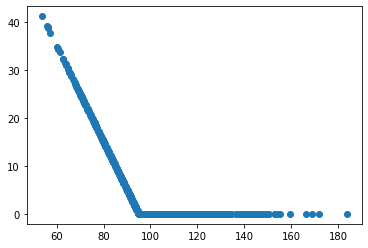

In [40]:
plt.scatter(X_train, Y_train)

In [41]:
S = np.arange(60,120)
V = np.zeros(S.shape)

V = nn.predict(np.array(S).reshape(-1,1))

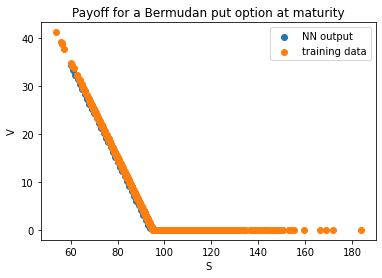

In [42]:
plt.scatter(S,V, label="NN output")
plt.scatter(X_train, Y_train, label="training data")
plt.legend()
plt.xlabel("S")
plt.ylabel("V")
plt.title("Payoff for a Bermudan put option at maturity")
plt.savefig("figures/put_at_maturity_NN.jpg", dpi=300)

In [43]:
# NN payoff at later times

In [44]:
Y_train = np.maximum(K - s_all[:,-1], 0)

X_train = s_all[:,-1]

In [45]:
m=1
V = np.zeros(len(nf.stock_paths[:,nf.dates[m]]))

for s in range(len(nf.stock_paths[:,nf.dates[m]])): 
    V[s] = np.sum(nf.opt_val[:,m,s])

h = np.maximum(0, nf.K - nf.stock_paths[:,dates[m]])

for i, value in enumerate(h):
    if value > V[i]:
        Y_train[i] = value
    else:
        Y_train[i] = V[i]
#Y_train = np.maximum(nf.h, V)

X_train = np.array(nf.stock_paths[:,dates[m]]).reshape(1,-1)

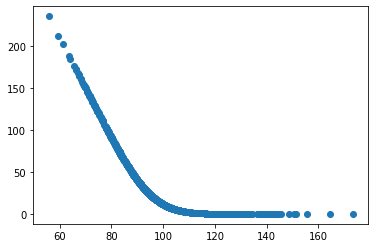

In [46]:
plt.scatter(X_train, Y_train)

In [47]:
S=np.arange(50,180)

In [48]:
V = nf.nnets[m].predict(np.array(S).reshape(-1,1))

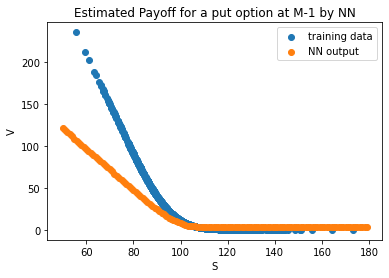

In [49]:
plt.scatter(X_train, Y_train, label="training data")
plt.scatter(S,V, label="NN output")
#plt.scatter(X_train, Y_train, label="training data")
plt.legend()
plt.xlabel("S")
plt.ylabel("V")
plt.title(f"Estimated Payoff for a put option at M-{m} by NN")
plt.savefig(f"figures/M-{m}_payoff_NN.jpg", dpi=300)